In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [341]:
data = pd.read_csv('../Data/dataset_1000_minimum_reviews.csv', index_col='Unnamed: 0')
df = data[['time', 'movie_id', 'user_id', 'binary_rating']]
df.head()

,time,movie_id,user_id,binary_rating
0,0,1197,3669,0
1,1,780,3621,0
2,2,1234,4917,0
3,3,1544,1147,0
4,4,3175,262,1


In [342]:
def policy_evaluator_moss(dataframe, alpha):
    # We stock the payoffs in a list
    payoffs = []
    # We pull each arm once to initialize history
    history = dataframe.groupby('movie_id').first()
    arms = dataframe['movie_id'].unique()
    n_arms = len(arms)
    history['movie_id'] = history.index
    # We drop the rows associated to the initial pull
    rows_to_drop = history['time']
    history['time'] = 0
    dataframe_copy = dataframe.copy()
    dataframe_copy.drop(rows_to_drop, inplace=True)
    dataframe_copy.reset_index(drop=True, inplace=True)
    dataframe_copy['time'] = dataframe_copy.index
    # We create a dict containing all the movies ID and their corresponding number of pulls
    s = {}
    for movie in arms:
        s[movie] = 1
    for t in range(1, len(dataframe_copy) + 1):
        # We get t-th row of our dataframe
        t_event = dataframe_copy[t-1:t]
        # We get the recommendation of our algorithm
        objective_function = {}
        for k in arms:
            objective_function[k] = history[history['movie_id'] == k]['binary_rating'].mean() + np.sqrt( ( (1 + alpha) / 2) * max(np.log( t / (n_arms * s[k] ) ), 0) / s[k] )
        
        arm_chosen = max(objective_function, key=objective_function.get)

        s[arm_chosen] += 1

        if arm_chosen == t_event['movie_id'].iloc[0]:
            history.loc[len(history)] = t_event.iloc[0].to_list()
            payoffs.append(t_event['binary_rating'].iloc[0])

    return payoffs

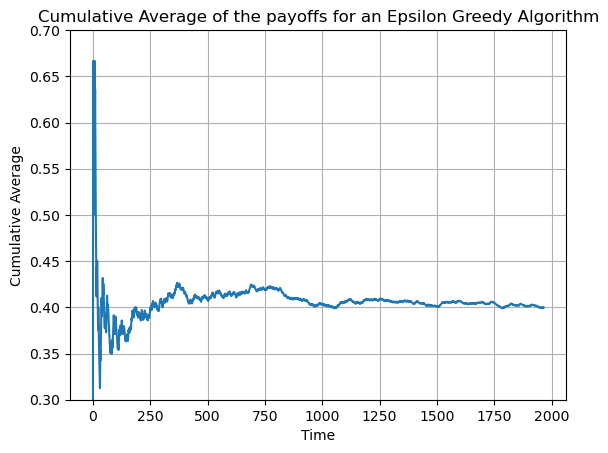

In [12]:
cumulative_average = np.cumsum(payoffs) / np.arange(1, len(payoffs)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for an Epsilon Greedy Algorithm")
plt.ylim(0.3, 0.7)
plt.grid(True)
plt.show()

In [15]:
pd.DataFrame(payoffs).to_csv('moss_anytime_1.35.csv')

As our code above takes quite a long time to execute, we thought about using groupby to accelerate our code.

In [343]:
def policy_evaluator_moss_anytime_random(dataframe, alpha):
    # We stock the payoffs in a list
    payoffs = []
    # We pull each arm once to initialize history
    history = dataframe.groupby('movie_id').first()
    arms = dataframe['movie_id'].unique()
    n_arms = len(arms)
    history['movie_id'] = history.index
    # We drop the rows associated to the initial pull
    rows_to_drop = history['time']
    history['time'] = 0
    history.reset_index(drop=True, inplace=True)
    history = history[dataframe.columns]
    dataframe_copy = dataframe.copy()
    dataframe_copy.drop(rows_to_drop, inplace=True)
    dataframe_copy.reset_index(drop=True, inplace=True)
    dataframe_copy['time'] = dataframe_copy.index
    for t in range(1, len(dataframe_copy) + 1):
        # We get t-th row of our dataframe
        t_event = dataframe_copy[t-1:t]
        # We get the recommendation of our algorithm
        # The groupby allows to get s without adding a dictionary. It also allows us to not have a loop over each arm.
        objective_function = history[['movie_id', 'binary_rating']].groupby('movie_id').agg({'binary_rating': ['mean', 'count']})
        objective_function.columns = ['mean', 'count']
        objective_function['value'] = objective_function['mean'] + objective_function['count'].apply(lambda count: np.sqrt( ((1 + alpha) / 2) * max(np.log(t / (n_arms * count)), 0) / count)) 
        
        # We check if there's only one argmax (one arm that maximizes the objective_function)
        max_value = objective_function['value'].max()
        if len(objective_function[objective_function['value'] == max_value]) == 1:
            
            arm_chosen = objective_function['value'].idxmax() # Our movies id are the index of our dataframe
        # If several arms are maximizing the objective function, we pick one randomly
        else:
            list_of_arms = objective_function[objective_function['value'] == objective_function['value'].max()].index.to_list()
            arm_chosen = random.choice(list_of_arms)

        if arm_chosen == t_event['movie_id'].iloc[0]:
            history.loc[len(history)] = t_event.iloc[0].to_list()
            payoffs.append(t_event['binary_rating'].iloc[0])

    return payoffs

In [344]:
def policy_evaluator_moss_anytime_min(dataframe, alpha):
    # We stock the payoffs in a list
    payoffs = []
    # We pull each arm once to initialize history
    history = dataframe.groupby('movie_id').first()
    arms = dataframe['movie_id'].unique()
    n_arms = len(arms)
    history['movie_id'] = history.index
    # We drop the rows associated to the initial pull
    rows_to_drop = history['time']
    history['time'] = 0
    history.reset_index(drop=True, inplace=True)
    history = history[dataframe.columns]
    dataframe_copy = dataframe.copy()
    dataframe_copy.drop(rows_to_drop, inplace=True)
    dataframe_copy.reset_index(drop=True, inplace=True)
    dataframe_copy['time'] = dataframe_copy.index
    for t in range(1, len(dataframe_copy) + 1):
        # We get t-th row of our dataframe
        t_event = dataframe_copy[t-1:t]
        # We get the recommendation of our algorithm
        # The groupby allows to get s without adding a dictionary. It also allows us to not have a loop over each arm.
        objective_function = history[['movie_id', 'binary_rating']].groupby('movie_id').agg({'binary_rating': ['mean', 'count']})
        objective_function.columns = ['mean', 'count']
        objective_function['value'] = objective_function['mean'] + objective_function['count'].apply(lambda count: np.sqrt( ((1 + alpha) / 2) * max(np.log(t / (n_arms * count)), 0) / count)) 
        
        # Even if several arms are maximizing the mean, we choose the arm with lowest id thanks to argmax
        arm_chosen = objective_function['value'].idxmax() # Our movies id are the index of our dataframe

        if arm_chosen == t_event['movie_id'].iloc[0]:
            history.loc[len(history)] = t_event.iloc[0].to_list()
            payoffs.append(t_event['binary_rating'].iloc[0])

    return payoffs

In [345]:
payoffs1 = policy_evaluator_moss_anytime_random(df, 1.35)

In [346]:
payoffs2 = policy_evaluator_moss_anytime_min(df, 1.35)

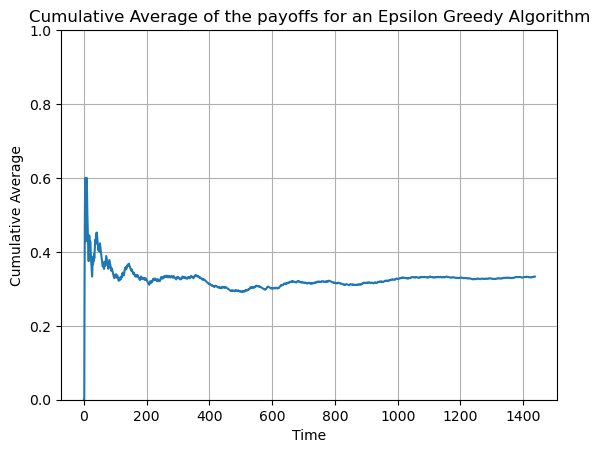

In [347]:
cumulative_average = np.cumsum(payoffs1) / np.arange(1, len(payoffs1)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for Moss-Anytime Algorithm (alpha = 1.35)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

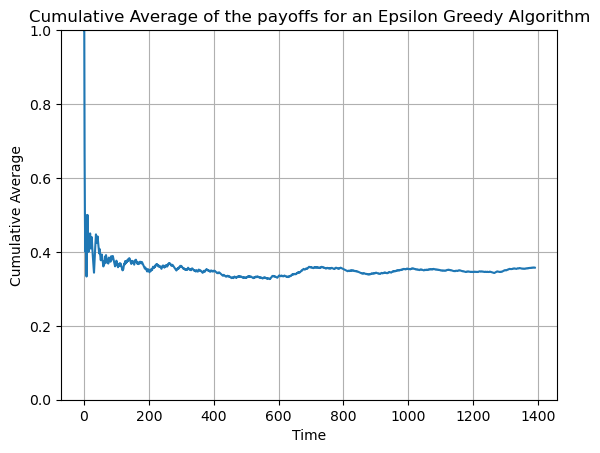

In [348]:
cumulative_average = np.cumsum(payoffs2) / np.arange(1, len(payoffs2)+1)

plt.plot(cumulative_average)
plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for Moss-Anytime Algorithm (alpha = 1.35)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

No differences between both algorithm, we thus decide to keep the argmin

In [351]:
pd.DataFrame(payoffs2).to_csv('moss_anytime_1.35.csv')

In [352]:
payoffs0 = policy_evaluator_moss_anytime_min(df, 0)
pd.DataFrame(payoffs0).to_csv('moss_anytime_0.csv')

In [353]:
payoffs02 = policy_evaluator_moss_anytime_min(df, 0.2)
pd.DataFrame(payoffs02).to_csv('moss_anytime_0.2.csv')

In [354]:
payoffs04 = policy_evaluator_moss_anytime_min(df, 0.4)
pd.DataFrame(payoffs04).to_csv('moss_anytime_0.4.csv')

In [355]:
payoffs06 = policy_evaluator_moss_anytime_min(df, 0.6)
pd.DataFrame(payoffs06).to_csv('moss_anytime_0.6.csv')

In [356]:
payoffs08 = policy_evaluator_moss_anytime_min(df, 0.8)
pd.DataFrame(payoffs08).to_csv('moss_anytime_0.8.csv')

In [357]:
payoffs10 = policy_evaluator_moss_anytime_min(df, 1)
pd.DataFrame(payoffs10).to_csv('moss_anytime_1.0.csv')

In [358]:
payoffs12 = policy_evaluator_moss_anytime_min(df, 1.2)
pd.DataFrame(payoffs12).to_csv('moss_anytime_1.2.csv')

In [361]:
alpha_values = [0, 0.4, 0.6, 0.8, 1.0, 1.2, 1.35]

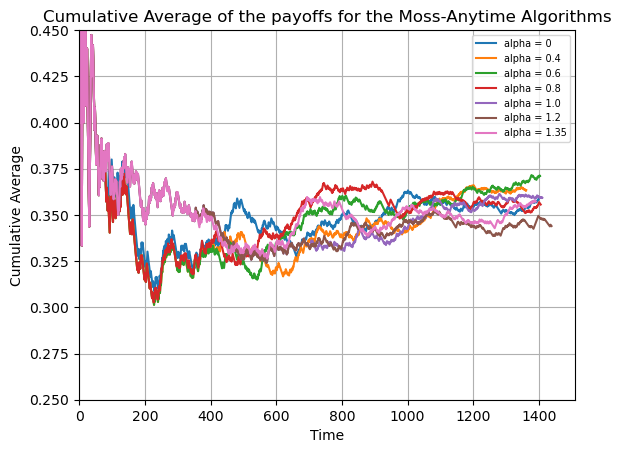

In [368]:
for alpha_value in alpha_values:
    filename = f'moss_anytime_{alpha_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'alpha = {alpha_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Moss-Anytime Algorithms")
plt.xlim(0,)
plt.ylim(0.25, 0.45)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

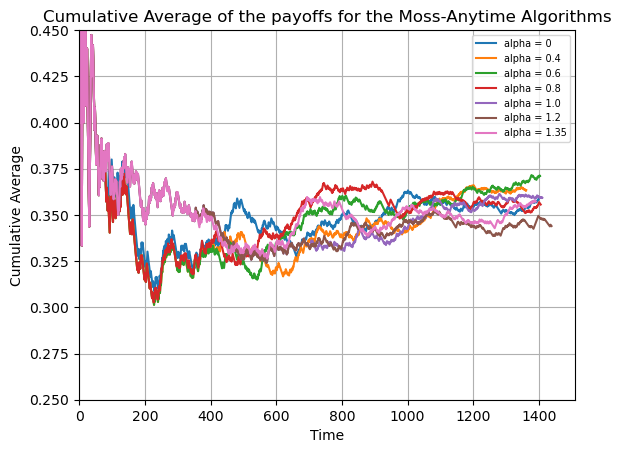

In [369]:
for alpha_value in alpha_values:
    payoffs = policy_evaluator_moss_anytime_min(df, alpha_value)
    pd.DataFrame(payoffs).to_csv(f'moss_anytime_{alpha_value}.csv')

for alpha_value in alpha_values:
    filename = f'moss_anytime_{alpha_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'alpha = {alpha_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Moss-Anytime Algorithms")
plt.xlim(0,)
plt.ylim(0.25, 0.45)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

In [370]:
for alpha_value in alpha_values:
    payoffs = policy_evaluator_moss_anytime_min(df, alpha_value)
    pd.DataFrame(payoffs).to_csv(f'moss_anytime_{alpha_value}.csv')

for alpha_value in alpha_values:
    filename = f'moss_anytime_{alpha_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'alpha = {alpha_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Moss-Anytime Algorithms")
plt.xlim(0,)
plt.ylim(0.25, 0.45)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

In [ ]:
for alpha_value in alpha_values:
    payoffs = policy_evaluator_moss_anytime_min(df, alpha_value)
    pd.DataFrame(payoffs).to_csv(f'moss_anytime_{alpha_value}.csv')

for alpha_value in alpha_values:
    filename = f'moss_anytime_{alpha_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'alpha = {alpha_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Moss-Anytime Algorithms")
plt.xlim(0,)
plt.ylim(0.25, 0.45)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()

In [ ]:
for alpha_value in alpha_values:
    payoffs = policy_evaluator_moss_anytime_min(df, alpha_value)
    pd.DataFrame(payoffs).to_csv(f'moss_anytime_{alpha_value}.csv')

for alpha_value in alpha_values:
    filename = f'moss_anytime_{alpha_value}.csv'
    rewards = pd.read_csv(filename, index_col='Unnamed: 0')
    rewards = np.array(rewards['0'])
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.plot(cumulative_average, label = f'alpha = {alpha_value}')

plt.xlabel("Time")
plt.ylabel("Cumulative Average")
plt.title("Cumulative Average of the payoffs for the Moss-Anytime Algorithms")
plt.xlim(0,)
plt.ylim(0.25, 0.45)
plt.grid(True)
plt.legend(fontsize=7)
plt.show()